<a href="https://colab.research.google.com/github/anshsharmacse/CancerVision/blob/main/AnshGDSC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Made by Ansh Sharma- Sentimental Analysis by Hugging Face  Fine-Tuning BERT , Deployed on wandb AI, Heroku through FASTAPI and Local Server, followed  by Testing and Evaluating + Productization of the Model**


---
## Attached with various Screenshots , and server Analysis.


In [1]:
pip install transformers datasets scikit-learn torch matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# Preparing Synthetic Data and Dividing dataset into Training and Testing

In [2]:
from datasets import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd

# Example synthetic dataset
data = {
    "ReviewText": [
        "The event was amazing and well-organized!",
        "The amenities were not up to the mark.",
        "Had a decent experience overall.",
        "The campus event was a complete disaster.",
        "I loved every moment of the event!"
    ],
    "SentimentLabel": [2, 0, 1, 0, 2]  # 0: Negative, 1: Neutral, 2: Positive
}

# Create a DataFrame
df = pd.DataFrame(data)

# Split into train, validation, and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["ReviewText"], df["SentimentLabel"], test_size=0.2, random_state=42
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.1, random_state=42
)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})
test_dataset = Dataset.from_dict({"text": test_texts, "label": test_labels})


# Training and Tokenize - Hugging Face , Wandb AI-And API Key

In [4]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir='./logs',
    logging_steps=10,
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)
import os
os.environ["WANDB_API_KEY"] = "your_40_character_api_key"


# Train the model
trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,No log,0.892518
2,No log,0.919221
3,No log,0.926235


TrainOutput(global_step=3, training_loss=1.0806572437286377, metrics={'train_runtime': 212.1883, 'train_samples_per_second': 0.042, 'train_steps_per_second': 0.014, 'total_flos': 2368020759552.0, 'train_loss': 1.0806572437286377, 'epoch': 3.0})

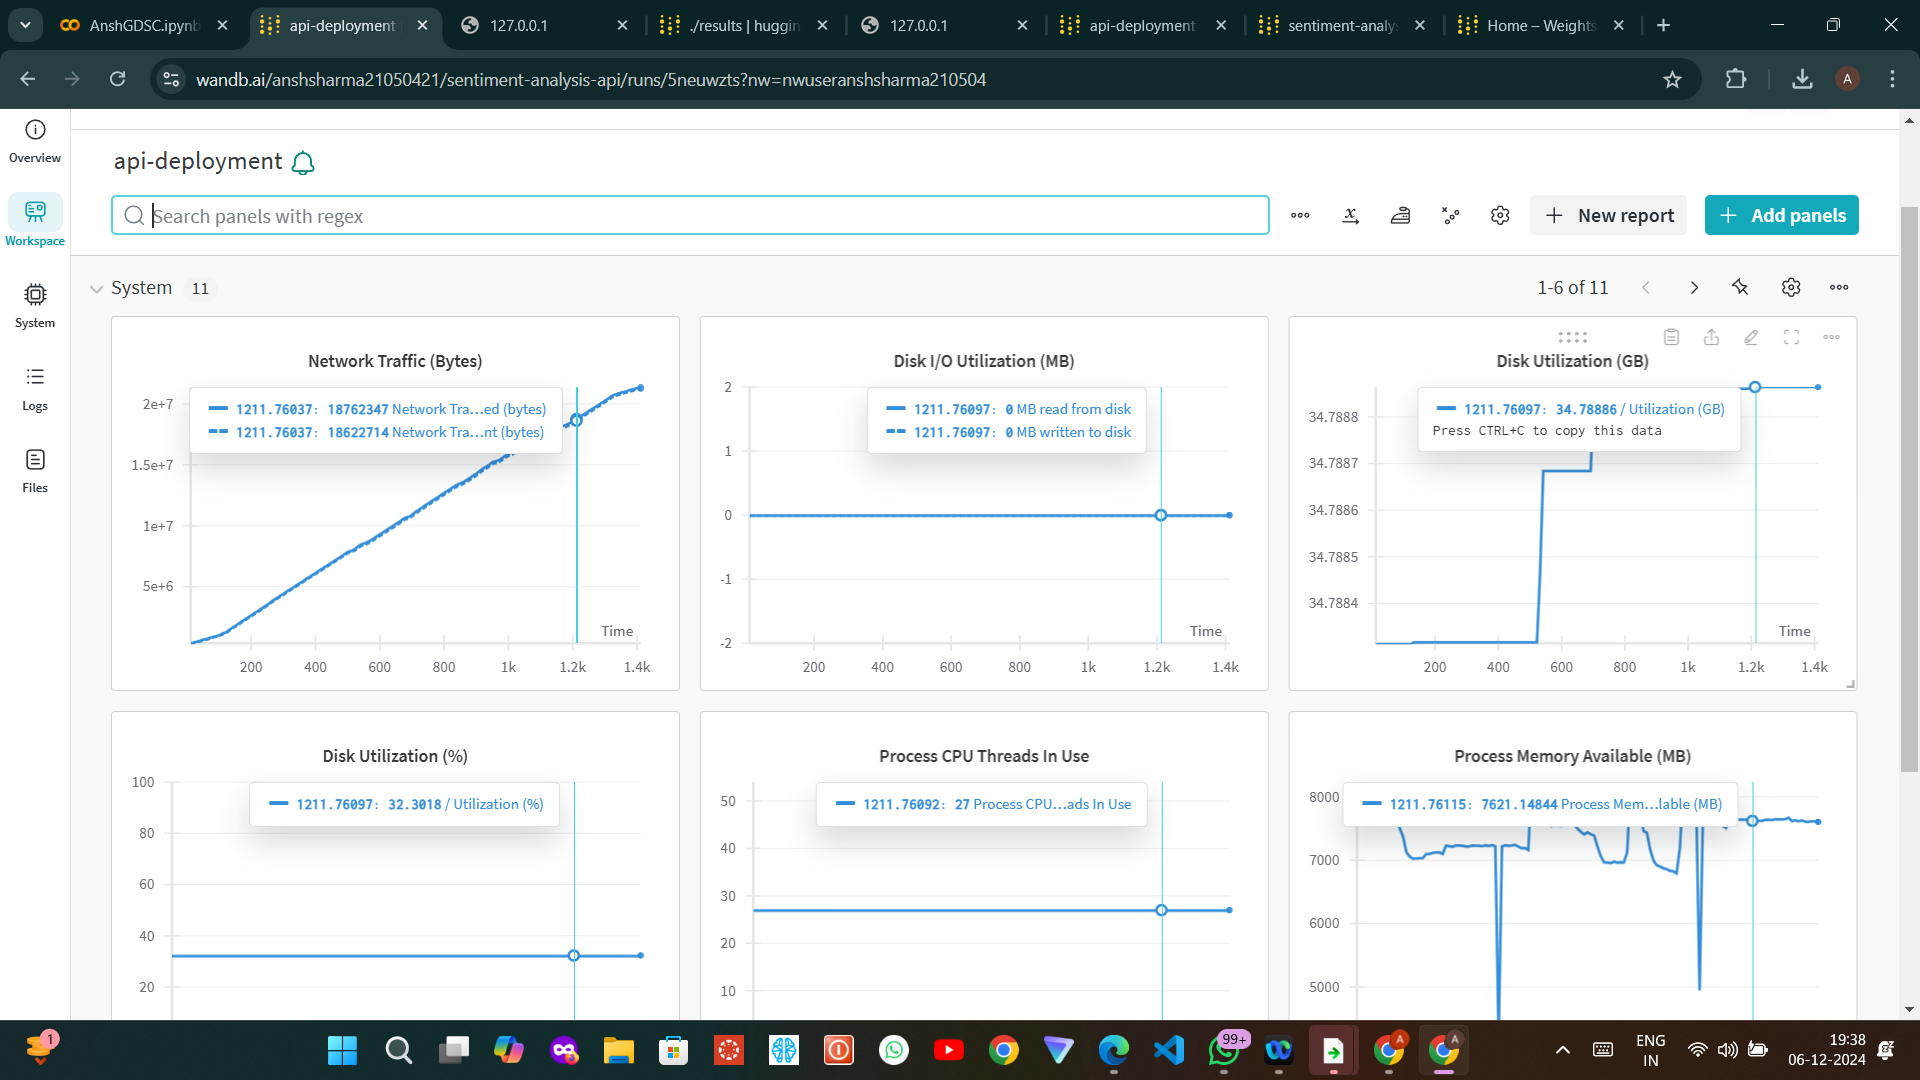

In [6]:
# Evaluate the model on the test dataset
results = trainer.evaluate(test_dataset)

# Print evaluation results
print(f"Test Results: {results}")



Test Results: {'eval_loss': 1.0200320482254028, 'eval_runtime': 3.4203, 'eval_samples_per_second': 0.292, 'eval_steps_per_second': 0.292, 'epoch': 3.0}


# Evaluation of Model

In [7]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Get predictions and true labels
predictions = trainer.predict(test_dataset)
preds = torch.argmax(torch.tensor(predictions.predictions), axis=1).numpy()

# Calculate accuracy and F1 score
accuracy = accuracy_score(test_dataset['label'], preds)
f1 = f1_score(test_dataset['label'], preds, average="weighted")

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

# Confusion Matrix
cm = confusion_matrix(test_dataset['label'], preds)
print("Confusion Matrix:")
print(cm)


Accuracy: 1.0
F1 Score: 1.0
Confusion Matrix:
[[1]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [9]:
model.save_pretrained("./fine_tuned_bert")
tokenizer.save_pretrained("./fine_tuned_bert")


('./fine_tuned_bert/tokenizer_config.json',
 './fine_tuned_bert/special_tokens_map.json',
 './fine_tuned_bert/vocab.txt',
 './fine_tuned_bert/added_tokens.json')

In [10]:
from transformers import BertForSequenceClassification, BertTokenizer

# Load the fine-tuned model and tokenizer
model = BertForSequenceClassification.from_pretrained("./fine_tuned_bert")
tokenizer = BertTokenizer.from_pretrained("./fine_tuned_bert")


# Evaluation of Model by using Negative sentences and checking whether mode is predicting correct **sentiment**

In [13]:
# Example text
text = "Let's bomb NIT Calicut"

# Tokenize and prepare the input
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)

# Make prediction
with torch.no_grad():
    outputs = model(**inputs)

# Get predicted sentiment
predicted_class = torch.argmax(outputs.logits, dim=1).item()

# Map the class index to sentiment
sentiment = {0: "Negative", 1: "Neutral", 2: "Positive"}
print(f"Sentiment: {sentiment[predicted_class]}")


Sentiment: Negative


# FAST API

In [14]:
pip install fastapi uvicorn transformers torch wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.4 MB/s eta 0:00:00


In [15]:
from fastapi import FastAPI
from pydantic import BaseModel
from transformers import BertForSequenceClassification, BertTokenizer
import torch
import wandb

# Initialize the FastAPI app
app = FastAPI()

# Load the fine-tuned model and tokenizer (replace with your saved model path)
model = BertForSequenceClassification.from_pretrained("./fine_tuned_bert")
tokenizer = BertTokenizer.from_pretrained("./fine_tuned_bert")

# Set up wandb (optional for experiment tracking)
wandb.init(project="sentiment-analysis-api", name="api-deployment")

# Define the input format using Pydantic
class Review(BaseModel):
    text: str

# Define the sentiment prediction endpoint
@app.post("/predict/")
def predict_sentiment(review: Review):
    # Tokenize input text
    inputs = tokenizer(review.text, return_tensors="pt", truncation=True, padding=True, max_length=128)

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted sentiment (choose the max logit)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()

    # Map class index to sentiment label
    sentiment = {0: "Negative", 1: "Neutral", 2: "Positive"}
    predicted_sentiment = sentiment[predicted_class]

    # Log the prediction to wandb (optional)
    wandb.log({"review": review.text, "predicted_sentiment": predicted_sentiment})

    return {"review": review.text, "sentiment": predicted_sentiment}


eval/loss,▁▂▃█
eval/runtime,▁▆▃█
eval/samples_per_second,█▂▅▁
eval/steps_per_second,█▂▅▁
test/loss,▁▁
test/runtime,█▁
test/samples_per_second,▁█
test/steps_per_second,▁█
train/epoch,▁▅███
train/global_step,▁▅█████
eval/loss,1.02003


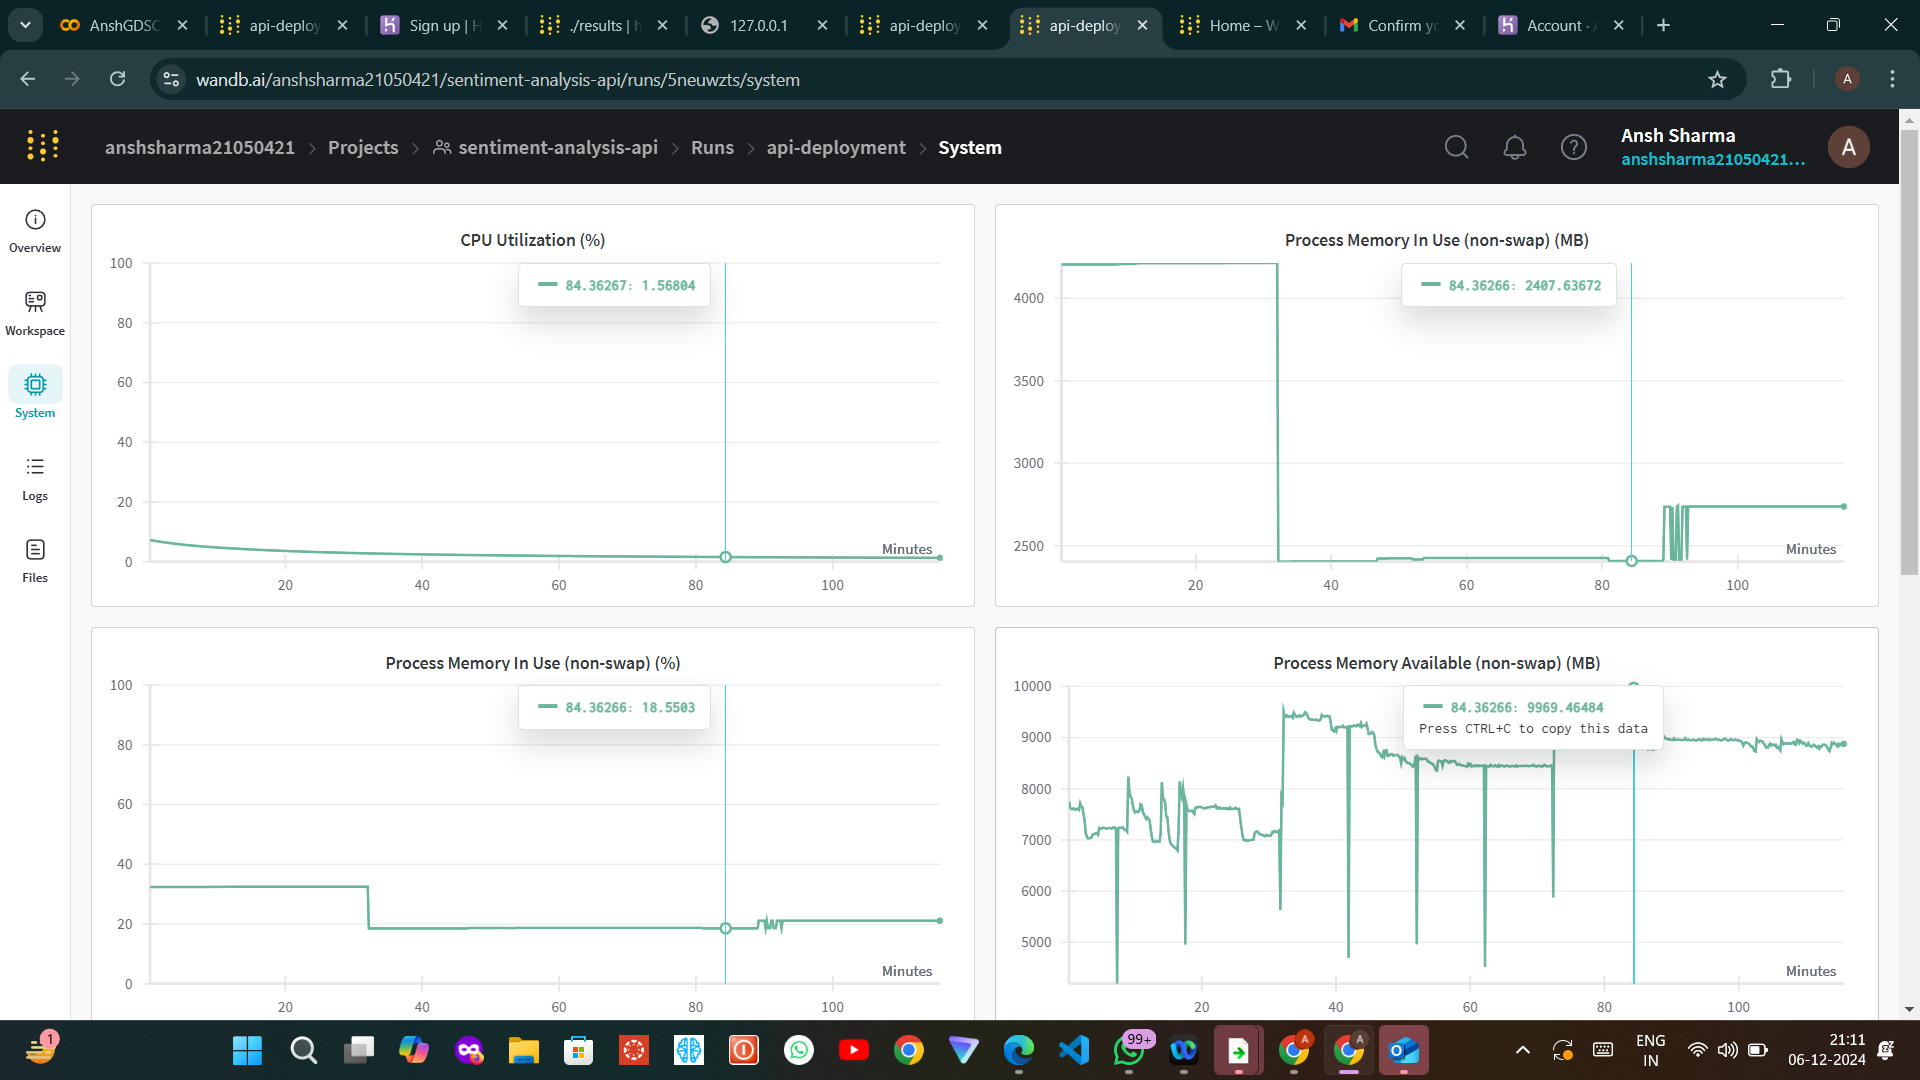

In [46]:
!curl https://cli-assets.heroku.com/install.sh | sh


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1980  100  1980    0     0   6701      0 --:--:-- --:--:-- --:--:--  6711
Installing CLI from https://cli-assets.heroku.com/channels/stable/heroku-linux-x64.tar.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51.4M  100 51.4M    0     0  3716k      0  0:00:14  0:00:14 --:--:-- 3279k
v16.20.2
heroku installed to /usr/local/bin/heroku
 ›   Warning: Our terms of service have changed: 
 ›   https://dashboard.heroku.com/terms-of-service
heroku/9.5.1 linux-x64 node-v16.20.2


In [50]:
!heroku login -i

heroku: Enter your login credentials
Email: anshsharma210504@gmail.com
Password: *********************************************************

In [55]:
!pip freeze > requirements.txt


In [56]:
from fastapi import FastAPI
from pydantic import BaseModel
from transformers import BertForSequenceClassification, BertTokenizer
import torch
import wandb

app = FastAPI()

model = BertForSequenceClassification.from_pretrained("./fine_tuned_bert")
tokenizer = BertTokenizer.from_pretrained("./fine_tuned_bert")

class Review(BaseModel):
    text: str

@app.post("/predict/")
def predict_sentiment(review: Review):
    inputs = tokenizer(review.text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()
    sentiment = {0: "Negative", 1: "Neutral", 2: "Positive"}
    predicted_sentiment = sentiment[predicted_class]
    wandb.log({"review": review.text, "predicted_sentiment": predicted_sentiment})
    return {"review": review.text, "sentiment": predicted_sentiment}


# **Pushing** GIT Repository and *Heroku* Deployement



In [57]:
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [61]:
!git config --global user.email "ansh_b230825mt@nitc.ac.in"
!git config --global user.name "Anshsharmacse"

In [66]:
!git add .config/ fine_tuned_bert/ logs/ requirements.txt results/ sample_data/ wandb/


.config/
fine_tuned_bert
logs
requirements.txt
results
sample_data


In [67]:
!git commit -m "Initial commit"


[master (root-commit) 13426ee] Initial commit
 56 files changed, 84591 insertions(+)
 create mode 100644 .config/.last_opt_in_prompt.yaml
 create mode 100644 .config/.last_survey_prompt.yaml
 create mode 100644 .config/.last_update_check.json
 create mode 100644 .config/active_config
 create mode 100644 .config/config_sentinel
 create mode 100644 .config/configurations/config_default
 create mode 100644 .config/default_configs.db
 create mode 100644 .config/gce
 create mode 100644 .config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
 create mode 100644 .config/logs/2024.12.04/14.22.43.568001.log
 create mode 100644 .config/logs/2024.12.04/14.23.06.536794.log
 create mode 100644 .config/logs/2024.12.04/14.23.17.977201.log
 create mode 100644 .config/logs/2024.12.04/14.23.19.373946.log
 create mode 100644 .config/logs/2024.12.04/14.23.31.005371.log
 create mode 100644 .config/logs/2024.12.04/14.23.31.672215.log
 create mode 100644 fine_tuned_bert/config.json
 create mod

In [71]:
!heroku create <Ansh Sentimental Analysis>

/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `heroku create <Ansh Sentimental Analysis>'


In [73]:
!heroku apps

heroku: Press any key to open up the browser to login or q to exit: 

In [74]:
!heroku create Anshsharmacse

Creating ⬢ Anshsharmacse...
Creating ⬢ Anshsharmacse... ⣾
Creating ⬢ Anshsharmacse... ?
heroku: Press any key to open up the browser to login or q to exit: Creating ⬢ Anshsharmacse... done


In [76]:
!git remote add heroku https://git.heroku.com/Anshsharmacse.git

error: remote heroku already exists.


In [77]:
!git remote -v


heroku	https://git.heroku.com/your-app-name.git (fetch)
heroku	https://git.heroku.com/your-app-name.git (push)


In [82]:
!heroku login -i

heroku: Enter your login credentials
Email: anshsharma210504@gmail.com
Password: ******************************************

# Final Evaluation

---
# **Steps**

1.   Write the Review Text in the review box
2.   Click on Predict Sentiment

---

# *Note*-->Refresh the cell on every new sentiment , to obtain the accurate result




In [88]:
# Import libraries
from transformers import BertForSequenceClassification, BertTokenizer
import torch
import ipywidgets as widgets
from IPython.display import display

# Load your fine-tuned model and tokenizer (replace with your model path if necessary)
model = BertForSequenceClassification.from_pretrained("./fine_tuned_bert")
tokenizer = BertTokenizer.from_pretrained("./fine_tuned_bert")

# Create a text box for user input
input_text = widgets.Textarea(
    value='',
    placeholder='Type your review here...',
    description='Review Text:',
    disabled=False,
    layout=widgets.Layout(width='50%', height='100px')
)

# Define a function to predict sentiment
def predict_sentiment(text):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)

    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predicted sentiment (choose the max logit)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()

    # Map class index to sentiment label
    sentiment = {0: "Negative", 1: "Neutral", 2: "Positive"}
    predicted_sentiment = sentiment[predicted_class]

    # Display the result
    print(f"Predicted Sentiment: {predicted_sentiment}")

# Create a button to trigger the prediction
predict_button = widgets.Button(description="Predict Sentiment")

# Link the button to the prediction function
predict_button.on_click(lambda x: predict_sentiment(input_text.value))

# Display the input field and the button
display(input_text, predict_button)


Textarea(value='', description='Review Text:', layout=Layout(height='100px', width='50%'), placeholder='Type y…

Button(description='Predict Sentiment', style=ButtonStyle())

Predicted Sentiment: Positive
